In [4]:
!pip install tensorflow==2.16.1 mlflow pandas scikit-learn matplotlib seaborn "Jinja2~=3.1.0"

  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached mlflow-3.1.1-py3-none-any.whl.metadata (29 kB)
  Using cached pandas-2.3.0-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.14.0-cp311-cp311-win_amd64.whl.metadata (2.7 kB)
  Using ca

In [5]:
# --- Core Libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

# --- Scikit-Learn for data splitting and metrics ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- TensorFlow and Keras for Deep Learning ---
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import (
    EfficientNetB3,
    ResNet152V2,
    DenseNet121,
    InceptionV3,
    MobileNetV2
)

# --- MLflow for Experiment Tracking ---
import mlflow
import mlflow.keras

# --- Set a consistent and professional style for our plots ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"MLflow Version: {mlflow.__version__}")

Libraries imported successfully.
TensorFlow Version: 2.16.1
MLflow Version: 3.1.1


In [6]:
class Config:
    """
    A centralized configuration class to hold all project-wide settings.
    This makes the code cleaner and experiments easier to reproduce and modify.
    """
    # --- Dataset and Path Configuration ---
    DATA_DIR = 'Rice_Image_Dataset'

    # --- Model and Training Hyperparameters ---
    IMAGE_SIZE = (224, 224)  # Input size for most modern CNNs
    BATCH_SIZE = 32          # Increased batch size for potentially faster training on capable hardware
    EPOCHS = 50              # Maximum number of epochs for training
    LEARNING_RATE = 0.0001   # A small learning rate is good for transfer learning

    # --- Data Splitting ---
    TEST_SIZE = 0.15         # 15% of data for the final test set
    VAL_SIZE = 0.15          # 15% of the *remaining* data for the validation set

    # --- Callbacks Configuration ---
    EARLY_STOPPING_PATIENCE = 3 # Stop training if val_accuracy doesn't improve for 3 epochs
    REDUCE_LR_PATIENCE = 2      # Reduce learning rate if val_loss doesn't improve for 2 epochs
    REDUCE_LR_FACTOR = 0.2      # Reduce LR by a factor of 0.2 (e.g., 0.001 -> 0.0002)

    # --- Reproducibility ---
    RANDOM_SEED = 42

# --- Set all random seeds to ensure our results are reproducible ---
np.random.seed(Config.RANDOM_SEED)
tf.random.set_seed(Config.RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(Config.RANDOM_SEED)

# Instantiate the config object for use throughout the notebook
config = Config()
print("Configuration is set and random seeds are initialized.")

Configuration is set and random seeds are initialized.


In [7]:
# --- Set up the MLflow experiment ---
# This will create a new experiment if it doesn't exist, or use the existing one.
EXPERIMENT_NAME = "Rice Variety Classification"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow experiment '{EXPERIMENT_NAME}' is ready.")
print(f"To view the UI, run 'mlflow ui' in your terminal from this directory.")

2025/06/27 00:47:18 INFO mlflow.tracking.fluent: Experiment with name 'Rice Variety Classification' does not exist. Creating a new experiment.


MLflow experiment 'Rice Variety Classification' is ready.
To view the UI, run 'mlflow ui' in your terminal from this directory.


Found 75000 images belonging to 5 classes.


C:\Users\User\AppData\Local\Temp\ipykernel_47876\2522674801.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')


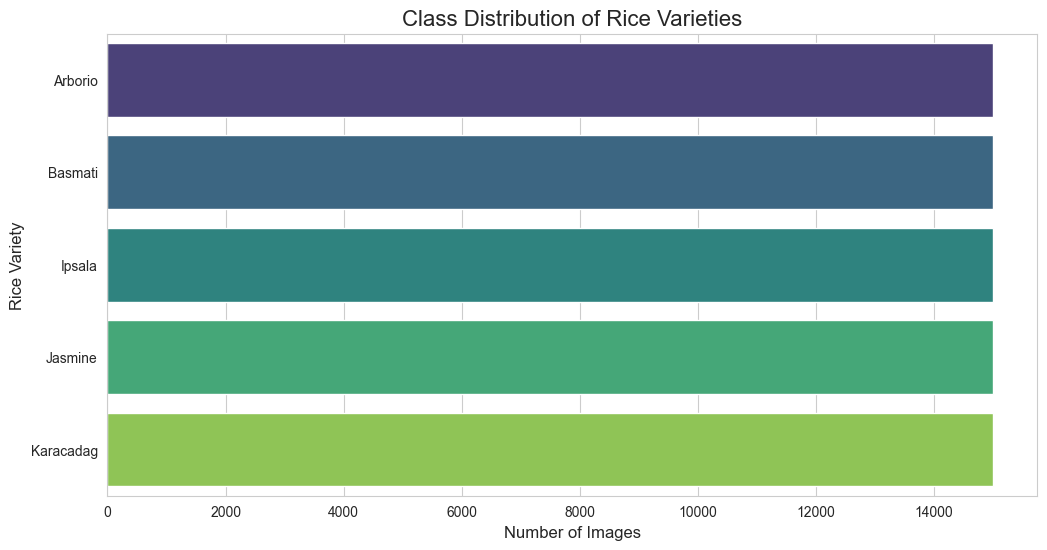


Displaying one sample image from each class:


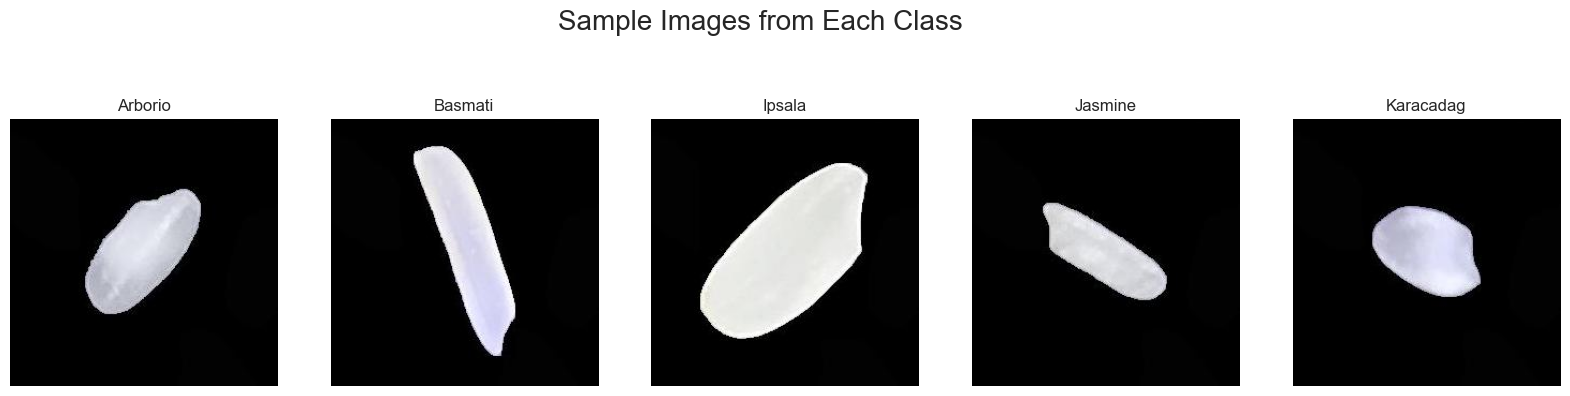

In [8]:
def load_data_for_eda(data_dir):
    """Loads image paths and labels into a Pandas DataFrame for easy analysis."""
    filepaths = []
    labels = []
    # List all subdirectories, which are our classes
    class_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for folder in class_folders:
        folder_path = os.path.join(data_dir, folder)
        files = os.listdir(folder_path)
        for file in files:
            filepaths.append(os.path.join(folder_path, file))
            labels.append(folder)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

# Create the DataFrame
df = load_data_for_eda(config.DATA_DIR)
print(f"Found {df.shape[0]} images belonging to {df['label'].nunique()} classes.")

# --- 1. Class Distribution ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')
plt.title('Class Distribution of Rice Varieties', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Rice Variety', fontsize=12)
plt.show()

# --- 2. Display Sample Images ---
print("\nDisplaying one sample image from each class:")
fig, axes = plt.subplots(1, df['label'].nunique(), figsize=(20, 5))
for i, label in enumerate(df['label'].unique()):
    sample_path = df[df['label'] == label].sample(1, random_state=config.RANDOM_SEED).iloc[0]['filepath']
    img = plt.imread(sample_path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')
plt.suptitle('Sample Images from Each Class', fontsize=20)
plt.show()

In [9]:
# --- Stratified Data Splitting ---
# We split the data into a training+validation set and a final, held-out test set.
# Stratifying by 'label' ensures that all sets have a similar class distribution.
train_val_df, test_df = train_test_split(
    df,
    test_size=config.TEST_SIZE,
    stratify=df['label'],
    random_state=config.RANDOM_SEED
)

# Split the training+validation set further into dedicated training and validation sets.
train_df, val_df = train_test_split(
    train_val_df,
    test_size=config.VAL_SIZE / (1 - config.TEST_SIZE), # Adjust proportion for correct split
    stratify=train_val_df['label'],
    random_state=config.RANDOM_SEED
)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# --- Data Augmentation and Generators ---
# The training generator applies many random transformations to the images.
# This helps the model learn to recognize rice varieties from different angles and lighting conditions.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# The validation and test generators ONLY rescale the images.
# We don't augment them because we need a consistent benchmark for evaluation.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Create the Generators from our DataFrames ---
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=config.RANDOM_SEED
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # No need to shuffle validation data
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # CRITICAL: Do not shuffle test data for final evaluation
)

# Get class names in the order the generator recognizes them
CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print(f"\nGenerators created. Found {NUM_CLASSES} classes: {CLASS_NAMES}")

Training samples: 52500
Validation samples: 11250
Test samples: 11250
Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.

Generators created. Found 5 classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [10]:
def create_model(base_model_class, input_shape, num_classes, trainable_layers=10):
    """
    Creates a transfer learning model with a specified base and a custom classification head.

    Args:
        base_model_class: The Keras application class (e.g., EfficientNetB3).
        input_shape (tuple): The shape of the input images (e.g., (224, 224, 3)).
        num_classes (int): The number of output classes.
        trainable_layers (int): The number of layers to unfreeze at the end of the base model.

    Returns:
        A compiled Keras model.
    """
    # Load the pre-trained base model without its top classification layer.
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the majority of the layers to leverage pre-trained knowledge.
    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    # Create our custom classification head.
    inputs = Input(shape=input_shape)
    # We pass the input through the base model. `training=False` is important
    # to keep batch norm layers in inference mode.
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x) # Averages the spatial features, reducing parameters.
    x = BatchNormalization()(x) # Stabilizes training.
    x = Dropout(0.4)(x) # Regularization to prevent overfitting.
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x) # Output layer with softmax for multi-class classification.

    model = Model(inputs, outputs)
    
    # Compile the model with an optimizer, loss function, and metrics.
    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE),
        loss='categorical_crossentropy', # Standard for multi-class classification
        metrics=['accuracy']
    )

    return model

# --- Dictionary of models we want to test ---
# We map a name to the Keras application class.
models_to_test = {
    "EfficientNetB3": EfficientNetB3,
    "ResNet152V2": ResNet152V2,
    "DenseNet121": DenseNet121,
    "InceptionV3": InceptionV3,
    "MobileNetV2": MobileNetV2  # A good lightweight option
}

In [11]:
for model_name, model_class in models_to_test.items():
    
    # This 'with' block ensures that all logging for this model is contained in a single MLflow run.
    with mlflow.start_run(run_name=f"run_{model_name}"):
        print(f"\n{'='*50}")
        print(f"🚀 Starting training for: {model_name}")
        print(f"{'='*50}")

        # --- Log parameters to MLflow ---
        # This helps us remember exactly how each model was trained.
        mlflow.log_params({
            "model_name": model_name,
            "learning_rate": config.LEARNING_RATE,
            "image_size": config.IMAGE_SIZE[0],
            "batch_size": config.BATCH_SIZE,
            "max_epochs": config.EPOCHS,
            "early_stopping_patience": config.EARLY_STOPPING_PATIENCE
        })

        # --- Create the model ---
        model = create_model(
            model_class,
            input_shape=(*config.IMAGE_SIZE, 3),
            num_classes=NUM_CLASSES
        )

        # --- Define callbacks for smart training ---
        callbacks = [
            # Stop training early if validation accuracy doesn't improve.
            EarlyStopping(
                monitor='val_accuracy',
                patience=config.EARLY_STOPPING_PATIENCE,
                restore_best_weights=True, # Automatically load the weights from the best epoch
                verbose=1
            ),
            # Reduce the learning rate if the model plateaus.
            ReduceLROnPlateau(
                monitor='val_loss',
                patience=config.REDUCE_LR_PATIENCE,
                factor=config.REDUCE_LR_FACTOR,
                min_lr=1e-7, # Don't let the LR get too small
                verbose=1
            )
        ]

        # --- Train the model ---
        start_time = time.time()
        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=config.EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training for {model_name} finished in {training_time:.2f} seconds.")

        # --- Evaluate on the held-out test set ---
        print(f"Evaluating {model_name} on the test set...")
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
        print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")

        # --- Log metrics to MLflow ---
        # We log both the final validation metrics and the test metrics.
        mlflow.log_metrics({
            "final_val_accuracy": history.history['val_accuracy'][-1],
            "final_val_loss": history.history['val_loss'][-1],
            "test_accuracy": test_accuracy,
            "test_loss": test_loss,
            "training_time_seconds": training_time
        })

        # --- Log the model to MLflow ---
        # This saves the model architecture, weights, and even the conda environment.
        # It's the best way to save models for later use.
        mlflow.keras.log_model(model, artifact_path=model_name)
        print(f"✅ Successfully trained and logged {model_name} to MLflow.")

print("\n🎉 All models have been trained and logged.")

2025/06/27 00:47:41 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet




🚀 Starting training for: EfficientNetB3


c:\Users\User\Desktop\datathon\variety\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1270s 766ms/step - accuracy: 0.2996 - loss: 1.8883 - val_accuracy: 0.5988 - val_loss: 1.0432 - learning_rate: 1.0000e-04
Epoch 2/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1281s 780ms/step - accuracy: 0.4167 - loss: 1.4032 - val_accuracy: 0.6420 - val_loss: 1.0671 - learning_rate: 1.0000e-04
Epoch 3/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1229s 749ms/step - accuracy: 0.4635 - loss: 1.2472 - val_accuracy: 0.7551 - val_loss: 0.8087 - learning_rate: 1.0000e-04
Epoch 4/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1161s 707ms/step - accuracy: 0.4980 - loss: 1.1577 - val_accuracy: 0.4602 - val_loss: 1.3589 - learning_rate: 1.0000e-04
Epoch 5/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1158s 706ms/step - accuracy: 0.5203 - loss: 1.0948 - val_accuracy: 0.7308 - val_loss: 0.7214 - learning_rate: 1.0000e-04
Epoch 6/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1191s 726ms/step - accuracy: 0.5351 - loss: 1.0513 - val_accuracy: 0.7079 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 6: early stoppin

2025/06/27 02:52:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 02:52:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Accuracy for EfficientNetB3: 0.7515


2025/06/27 02:52:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Successfully trained and logged EfficientNetB3 to MLflow.

🚀 Starting training for: ResNet152V2
Epoch 1/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2410s 1s/step - accuracy: 0.8766 - loss: 0.3701 - val_accuracy: 0.9731 - val_loss: 0.0736 - learning_rate: 1.0000e-04
Epoch 2/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2393s 1s/step - accuracy: 0.9597 - loss: 0.1192 - val_accuracy: 0.9840 - val_loss: 0.0494 - learning_rate: 1.0000e-04
Epoch 3/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2396s 1s/step - accuracy: 0.9673 - loss: 0.0982 - val_accuracy: 0.9889 - val_loss: 0.0333 - learning_rate: 1.0000e-04
Epoch 4/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2413s 1s/step - accuracy: 0.9726 - loss: 0.0793 - val_accuracy: 0.9889 - val_loss: 0.0315 - learning_rate: 1.0000e-04
Epoch 5/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2397s 1s/step - accuracy: 0.9742 - loss: 0.0737 - val_accuracy: 0.9890 - val_loss: 0.0341 - learning_rate: 1.0000e-04
Epoch 6/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 2388s 1s/step - accuracy: 0.9787 - loss: 0.0643 - val_accura

2025/06/27 14:23:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 14:23:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Accuracy for ResNet152V2: 0.9951


2025/06/27 14:24:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Successfully trained and logged ResNet152V2 to MLflow.

🚀 Starting training for: DenseNet121
Epoch 1/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1352s 819ms/step - accuracy: 0.8392 - loss: 0.4587 - val_accuracy: 0.9780 - val_loss: 0.0636 - learning_rate: 1.0000e-04
Epoch 2/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1333s 813ms/step - accuracy: 0.9693 - loss: 0.0869 - val_accuracy: 0.9802 - val_loss: 0.0558 - learning_rate: 1.0000e-04
Epoch 3/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1333s 812ms/step - accuracy: 0.9783 - loss: 0.0646 - val_accuracy: 0.9763 - val_loss: 0.0675 - learning_rate: 1.0000e-04
Epoch 4/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1326s 808ms/step - accuracy: 0.9812 - loss: 0.0546 - val_accuracy: 0.9812 - val_loss: 0.0524 - learning_rate: 1.0000e-04
Epoch 5/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1323s 806ms/step - accuracy: 0.9835 - loss: 0.0501 - val_accuracy: 0.9409 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 6/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9845 - loss: 0.0457


2025/06/27 17:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 17:02:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Accuracy for DenseNet121: 0.9821


2025/06/27 17:03:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Successfully trained and logged DenseNet121 to MLflow.

🚀 Starting training for: InceptionV3
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 794s 480ms/step - accuracy: 0.8336 - loss: 0.5029 - val_accuracy: 0.9778 - val_loss: 0.0633 - learning_rate: 1.0000e-04
Epoch 2/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 788s 480ms/step - accuracy: 0.9382 - loss: 0.1776 - val_accuracy: 0.9810 - val_loss: 0.0528 - learning_rate: 1.0000e-04
Epoch 3/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 789s 480ms/step - accuracy: 0.9472 - loss: 0.1490 - val_accuracy: 0.9851 - val_loss: 0.0432 - learning_rate: 1.0000e-04
Epoch 4/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 791s 482ms/step - accuracy: 0.9544 - loss: 0.1350 - val_accuracy: 0.9846 - val_loss: 0.0424 - learning_rate: 1.0000e-04
Epoch 5/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 789s 481ms/step - accuracy: 0.9560 - loss: 0.1263 - val_accuracy: 0.9857 - val_loss: 0.0395 - learning_rate: 1.0000e-04
Epoch 6/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 7

2025/06/27 20:09:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 20:09:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Accuracy for InceptionV3: 0.9897


2025/06/27 20:09:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Successfully trained and logged InceptionV3 to MLflow.

🚀 Starting training for: MobileNetV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 671s 406ms/step - accuracy: 0.8789 - loss: 0.3647 - val_accuracy: 0.9482 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 2/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 666s 406ms/step - accuracy: 0.9536 - loss: 0.1370 - val_accuracy: 0.9567 - val_loss: 0.1584 - learning_rate: 1.0000e-04
Epoch 3/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 666s 406ms/step - accuracy: 0.9637 - loss: 0.1046 - val_accuracy: 0.9708 - val_loss: 0.0895 - learning_rate: 1.0000e-04
Epoch 4/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 669s 408ms/step - accuracy: 0.9668 - loss: 0.0932 - val_accuracy: 0.9628 - val_loss: 0.1337 - learning_rate: 1.0000e-04
Epoch 5/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9682 - loss: 0.0892
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 667s 407ms

2025/06/27 21:17:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/27 21:17:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Accuracy for MobileNetV2: 0.9731


2025/06/27 21:17:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Successfully trained and logged MobileNetV2 to MLflow.

🎉 All models have been trained and logged.


C:\Users\User\AppData\Local\Temp\ipykernel_47876\404034146.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Accuracy', y='Model', data=runs, ax=axes[0], palette='Greens_r')
C:\Users\User\AppData\Local\Temp\ipykernel_47876\404034146.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Loss', y='Model', data=runs, ax=axes[1], palette='Reds_r')
C:\Users\User\AppData\Local\Temp\ipykernel_47876\404034146.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training Time (s)', y='Model', data=runs, ax=axes[2], palette='Blues

Found 5 runs in the 'Rice Variety Classification' experiment.


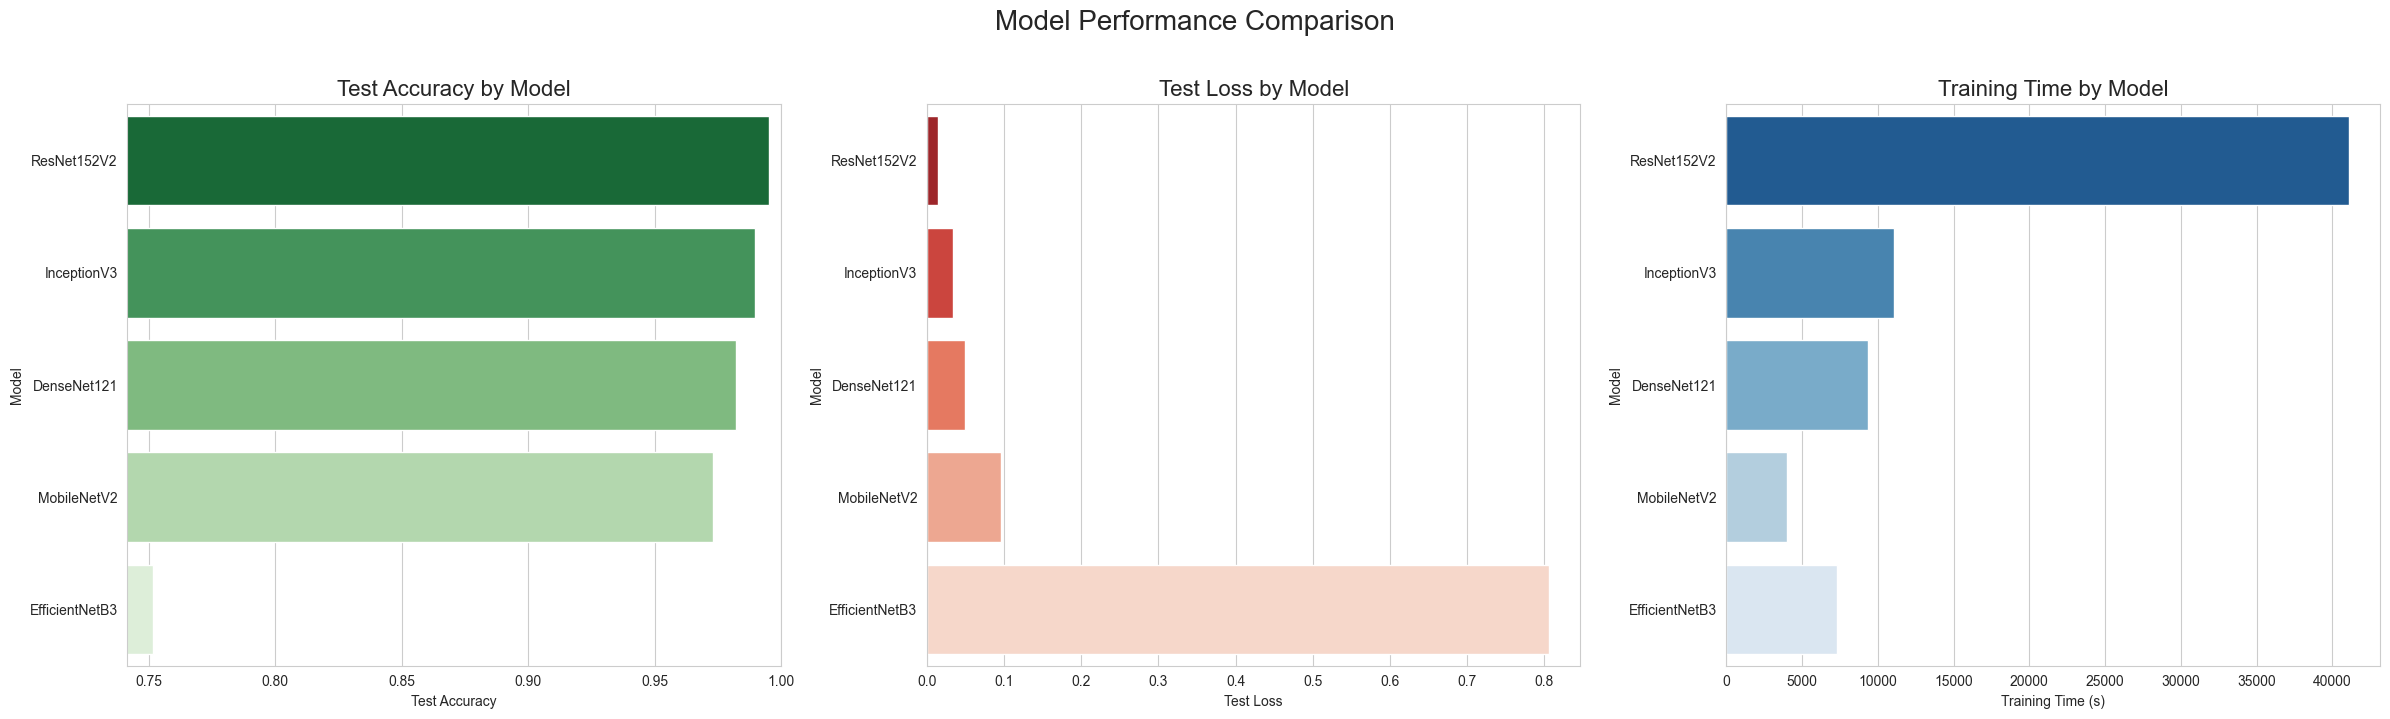


--- Detailed Performance Table ---


,Model,Test Accuracy,Test Loss,Training Time (s)
3,ResNet152V2,0.995111,0.013875,41087.332680
1,InceptionV3,0.989689,0.033613,11078.783047
2,DenseNet121,0.982133,0.049803,9321.593012
0,MobileNetV2,0.973067,0.095968,4004.595265
4,EfficientNetB3,0.751467,0.806684,7290.023522


In [12]:
# --- Load all experiment data from MLflow ---
# This fetches the parameters and metrics from every run in our experiment.
runs = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])
print(f"Found {len(runs)} runs in the '{EXPERIMENT_NAME}' experiment.")

# --- Prepare the data for plotting ---
# We clean up the column names for better readability in our charts.
runs.rename(columns={
    'params.model_name': 'Model',
    'metrics.test_accuracy': 'Test Accuracy',
    'metrics.test_loss': 'Test Loss',
    'metrics.training_time_seconds': 'Training Time (s)'
}, inplace=True)

# Sort by accuracy for a clean chart
runs.sort_values(by='Test Accuracy', ascending=False, inplace=True)

# --- Create Comparison Plots ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Model Performance Comparison', fontsize=20, y=1.02)

# 1. Test Accuracy Comparison
sns.barplot(x='Test Accuracy', y='Model', data=runs, ax=axes[0], palette='Greens_r')
axes[0].set_title('Test Accuracy by Model', fontsize=16)
axes[0].set_xlim([min(runs['Test Accuracy']) - 0.01, 1.0]) # Set x-axis limit up to 100%

# 2. Test Loss Comparison
sns.barplot(x='Test Loss', y='Model', data=runs, ax=axes[1], palette='Reds_r')
axes[1].set_title('Test Loss by Model', fontsize=16)

# 3. Training Time Comparison
sns.barplot(x='Training Time (s)', y='Model', data=runs, ax=axes[2], palette='Blues_r')
axes[2].set_title('Training Time by Model', fontsize=16)

plt.tight_layout()
plt.show()

# Display the raw data as a table for detailed view
print("\n--- Detailed Performance Table ---")
display(runs[['Model', 'Test Accuracy', 'Test Loss', 'Training Time (s)']])

The best performing model is 'ResNet152V2' with a test accuracy of 0.9951.
Loading model from MLflow for detailed evaluation...
Making predictions on the test set...
352/352 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step

--- Detailed Classification Report ---
              precision    recall  f1-score   support

     Arborio       0.99      1.00      0.99      2250
     Basmati       1.00      0.99      0.99      2250
      Ipsala       1.00      1.00      1.00      2250
     Jasmine       0.99      0.99      0.99      2250
   Karacadag       1.00      1.00      1.00      2250

    accuracy                           1.00     11250
   macro avg       1.00      1.00      1.00     11250
weighted avg       1.00      1.00      1.00     11250



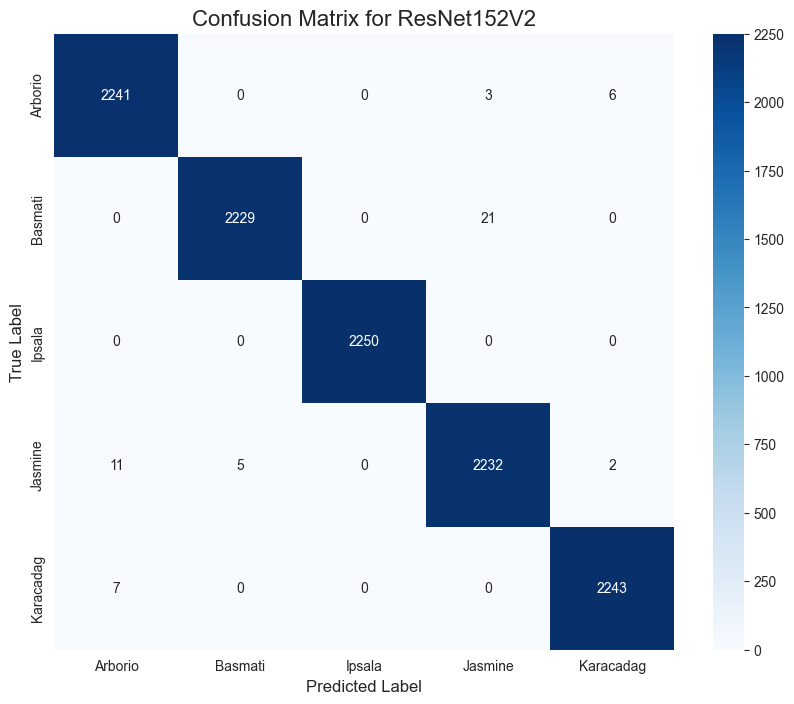

In [13]:
# --- Identify and load the best model ---
# We find the run with the highest test accuracy from our MLflow results.
best_run = runs.iloc[0]
best_model_name = best_run['Model']
best_model_uri = f"runs:/{best_run.run_id}/{best_model_name}"

print(f"The best performing model is '{best_model_name}' with a test accuracy of {best_run['Test Accuracy']:.4f}.")
print("Loading model from MLflow for detailed evaluation...")

# Load the model directly from the MLflow artifact store.
best_model = mlflow.keras.load_model(best_model_uri)

# --- Make predictions on the entire test set ---
print("Making predictions on the test set...")
# The predict() method returns the raw probability scores for each class.
y_pred_probs = best_model.predict(test_generator)
# We use argmax to get the index of the class with the highest probability.
y_pred_classes = np.argmax(y_pred_probs, axis=1)
# The true classes are stored in the generator.
y_true_classes = test_generator.classes

# --- Generate and Display Evaluation Metrics ---
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))

# --- Plot a Confusion Matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

Demonstrating prediction on a single image.
Image Path: Ipsala (14197).jpg
True Label: Ipsala
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


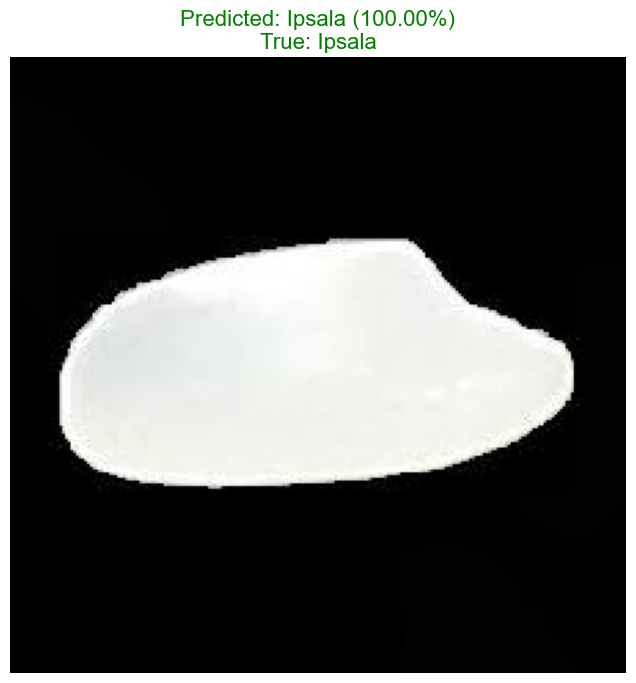


--- Class Probabilities ---
    Class  Probability
   Ipsala 1.000000e+00
  Arborio 3.572622e-16
Karacadag 6.678990e-17
  Jasmine 2.909876e-17
  Basmati 7.550767e-21

=== Notebook Complete ===


In [14]:
# --- Select a random image from the test set ---
sample_row = test_df.sample(1, random_state=config.RANDOM_SEED).iloc[0]
sample_path = sample_row['filepath']
true_label = sample_row['label']

print(f"Demonstrating prediction on a single image.")
print(f"Image Path: {os.path.basename(sample_path)}")
print(f"True Label: {true_label}")

# --- Load and preprocess the image ---
img = tf.keras.preprocessing.image.load_img(sample_path, target_size=config.IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0  # Rescale
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

# --- Make Prediction ---
prediction_probs = best_model.predict(img_array)[0]
predicted_class_index = np.argmax(prediction_probs)
predicted_class_name = CLASS_NAMES[predicted_class_index]
confidence = np.max(prediction_probs)

# --- Display the result ---
plt.figure(figsize=(8, 8))
plt.imshow(img)
title_text = f"Predicted: {predicted_class_name} ({confidence:.2%})\nTrue: {true_label}"
# Set title color to green if correct, red if incorrect
title_color = 'green' if predicted_class_name == true_label else 'red'
plt.title(title_text, color=title_color, fontsize=16)
plt.axis('off')
plt.show()

print("\n--- Class Probabilities ---")
# Display all class probabilities for this image, sorted by confidence
prob_df = pd.DataFrame({'Class': CLASS_NAMES, 'Probability': prediction_probs})
print(prob_df.sort_values(by='Probability', ascending=False).to_string(index=False))

print("\n=== Notebook Complete ===")

In [16]:
import mlflow
import pandas as pd

# Name of the experiment you defined in your notebook
EXPERIMENT_NAME = "Rice Variety Classification"

# Search all runs in the experiment and sort by test accuracy
runs = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])
runs.rename(columns={'metrics.test_accuracy': 'Test Accuracy'}, inplace=True)
best_run = runs.sort_values(by='Test Accuracy', ascending=False).iloc[0]

# Get the unique URI (address) of the best model artifact
best_model_uri = f"runs:/{best_run.run_id}/{best_run['params.model_name']}"

print(f"The best model is '{best_run['params.model_name']}'")
print(f"It can be loaded from this URI: {best_model_uri}")

The best model is 'ResNet152V2'
It can be loaded from this URI: runs:/b101fd849da240d29694804f3c13cccb/ResNet152V2


In [17]:
# Load the best model from MLflow
best_model = mlflow.keras.load_model(best_model_uri)

print("\n✅ Best model (ResNet152V2) has been successfully loaded.")
print(best_model.summary())


✅ Best model (ResNet152V2) has been successfully loaded.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,757,649 (254.66 MB)

 Trainable params: 3,945,989 (15.05 MB)

 Non-trainable params: 54,919,680 (209.50 MB)

 Optimizer params: 7,891,980 (30.11 MB)

None


\n--- Demonstrating prediction on a single image ---
Image Path: Karacadag (11493).jpg
True Label: Karacadag
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


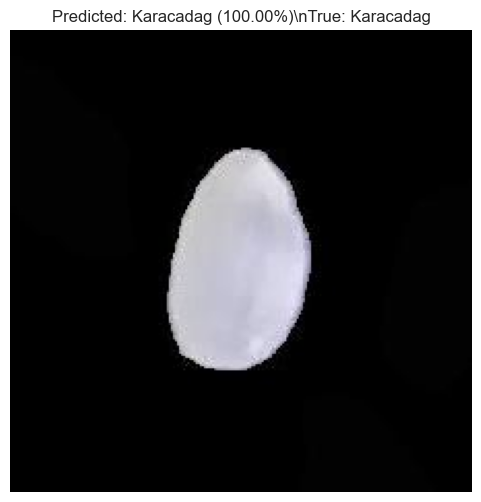

In [18]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- You will need the test_df DataFrame and Config class from earlier cells ---
# Assuming they are still in memory or you can re-run those cells.

# --- Select a random image from the test set ---
sample_row = test_df.sample(1).iloc[0]
sample_path = sample_row['filepath']
true_label = sample_row['label']

print(f"\\n--- Demonstrating prediction on a single image ---")
print(f"Image Path: {os.path.basename(sample_path)}")
print(f"True Label: {true_label}")

# --- Load and preprocess the image ---
img = tf.keras.preprocessing.image.load_img(sample_path, target_size=config.IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = img_array / 255.0  # Rescale
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

# --- Make Prediction ---
prediction_probs = best_model.predict(img_array)[0]
predicted_class_index = np.argmax(prediction_probs)
predicted_class_name = CLASS_NAMES[predicted_class_index]
confidence = np.max(prediction_probs)

# --- Display the result ---
plt.figure(figsize=(6, 6))
plt.imshow(img)
title_text = f"Predicted: {predicted_class_name} ({confidence:.2%})\\nTrue: {true_label}"
plt.title(title_text)
plt.axis('off')
plt.show()